<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/ALB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author: Tewabe Melkamu**

Date: 3/13/2025

ALB_Data Collection

In [ ]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-mftewabe')

# Loop data download

In [ ]:
# -------------------------------------------------------------------
# Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the FAO GAUL 2015 dataset to filter Taiwan
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# # -------------------------------------------------------------------
# # Load ESA WorldCover and create a land mask
# # -------------------------------------------------------------------
# # Load the first image from ESA WorldCover and clip it to Taiwan.
# worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)

# # Class definitions from ESA WorldCover:
# # 50 = Built-up, 80 = Permanent water bodies.
# # Remove built-up and permanent water by keeping pixels that are **not** 50 and **not** 80.
# mask = worldcover.neq(50).And(worldcover.neq(80))

# -------------------------------------------------------------------
#  Define the seasons
# -------------------------------------------------------------------
seasons = {
    "Winter": ('12-01', '02-28'),  # Adjusted February end date
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30')  # November has 30 days
}

# -------------------------------------------------------------------
# Loop through each year from 2000 to 2025 and process seasonal ALBEDO
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    for season, (start, end) in seasons.items():
        print(f"  Processing {season} of {year}")

        # Define the seasonal date range
        start_date = ee.Date(f"{year}-{start}")
        end_date = ee.Date(f"{year}-{end}")

        # Compute the mean ALBEDO for the season
        seasonal_albedo = (ee.ImageCollection("MODIS/061/MCD43A3")
                            .filterDate(start_date, end_date)
                            .filterBounds(taiwan)
                            .select('Albedo_WSA_Band1')
                            .mean()
                            .clip(taiwan))

        # Scale ALBEDO values (MODIS Albedo scale factor is 0.001)
        albedo_scaled = seasonal_albedo.multiply(0.001)

        # Apply the land mask (remove built-up areas & water bodies)
        #albedo_masked = albedo_scaled.updateMask(mask)

        # -------------------------------------------------------------------
        #  Export to Google Drive
        # -------------------------------------------------------------------
        task = ee.batch.Export.image.toDrive(
            image=albedo_scaled,
            description=f'ALB_{year}_{season}',  # Unique name per year & season
            folder='Taiwan_ALB',  # Update this to your desired Drive folder
            fileNamePrefix=f'ALB_{year}_{season}',
            region=taiwan.geometry().bounds().getInfo()['coordinates'],
            scale=1000,  # MODIS resolution (~1 km)
            crs='EPSG:32651',  # UTM Zone 51N for Taiwan
            maxPixels=1e13
        )

        task.start()
        print(f"Export task for {year} - {season} started.")



Processing year: 2000
  Processing Winter of 2000
Export task for 2000 - Winter started.
  Processing Spring of 2000
Export task for 2000 - Spring started.
  Processing Summer of 2000
Export task for 2000 - Summer started.
  Processing Autumn of 2000
Export task for 2000 - Autumn started.
Processing year: 2001
  Processing Winter of 2001
Export task for 2001 - Winter started.
  Processing Spring of 2001
Export task for 2001 - Spring started.
  Processing Summer of 2001
Export task for 2001 - Summer started.
  Processing Autumn of 2001
Export task for 2001 - Autumn started.
Processing year: 2002
  Processing Winter of 2002
Export task for 2002 - Winter started.
  Processing Spring of 2002
Export task for 2002 - Spring started.
  Processing Summer of 2002
Export task for 2002 - Summer started.
  Processing Autumn of 2002
Export task for 2002 - Autumn started.
Processing year: 2003
  Processing Winter of 2003
Export task for 2003 - Winter started.
  Processing Spring of 2003
Export task f

# Data exploration

In [ ]:
%pip install rasterio

Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


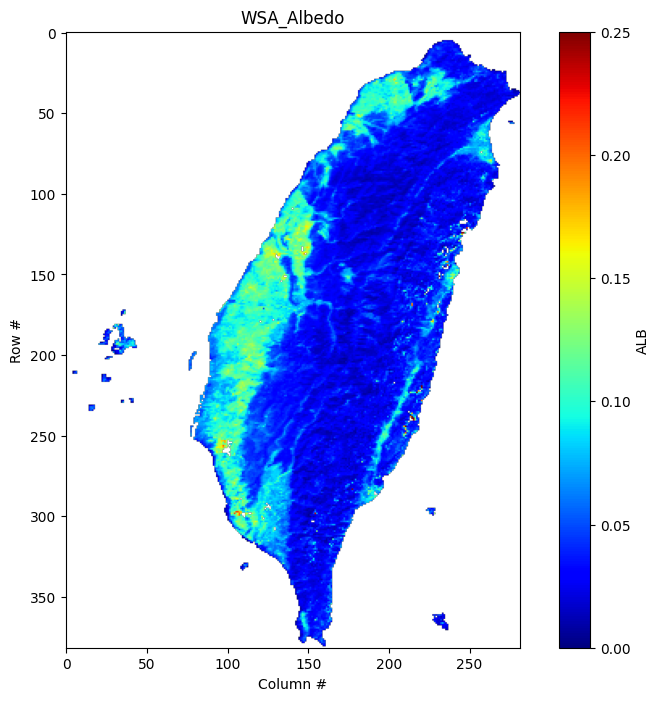

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/ALB/ALB_2024_Winter.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='ALB')
plt.title('WSA_Albedo')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()



# Histogram of the albedo data

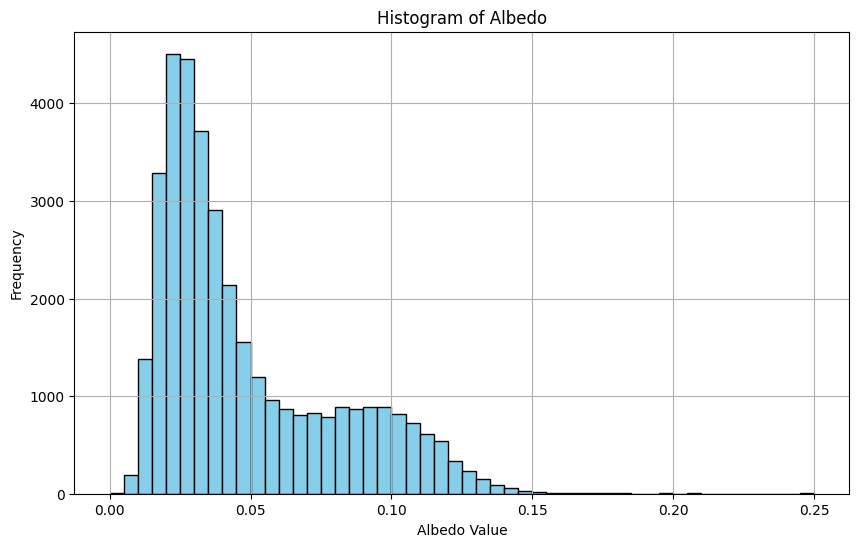

In [4]:
# prompt: histogram

import matplotlib.pyplot as plt
# Create a histogram of the albedo data
plt.figure(figsize=(10, 6))
plt.hist(ndvi_masked.compressed(), bins=50, color='skyblue', edgecolor='black')  # Use compressed() for masked arrays
plt.xlabel('Albedo Value')
plt.ylabel('Frequency')
plt.title('Histogram of Albedo')
plt.grid(True)
plt.show()
